# Machine Learning Methods for Empirical Dynamic Modeling

_Kevin Siswandi | July 2020_

We demonstrate a few approaches for empirical dynamic modeling with machine learning tools:
* One-step Learning
* LmmNet
* Recurrent Neural Network (maybe)

Here we will demonstrate it on the canonical 3-D Linear Oscillator. Later, we will try to see how it performs with noisy data. Finally, we see how the method can extract insights from what it has learnt from data.

In [1]:
# Install nodepy in the current Jupyter kernel
import sys
!pip install --user nodepy

     |████████████████████████████████| 818 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 77.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 71.5 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 758 kB/s  eta 0:00:01
     |████████████████████████████████| 512 kB 73.6 MB/s eta 0:00:01
  Created wheel for mpmath: filename=mpmath-1.1.0-py3-none-any.whl size=532239 sha256=047239738609b9f65ec8391ff422057a4bfcb6bb0a15cc15b6024d0a8c3cbe7b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e8/38/69/aa17553ad31f09ff5fa44c8a1a6c5b47e7c9261e9c7c16b9fb
Successfully built mpmath
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.


In [2]:
# upgrade to tensorflow to 2
!pip install --user --upgrade tensorflow

     |████████████████████████████████| 516.2 MB 5.2 kB/s  eta 0:00:01
     |████████████████████████████████| 454 kB 56.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 66.7 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 53.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 66.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 88 kB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 55.3 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 70.2 MB/s eta 0:00:01
     |███████████████████████████████

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import nodepy.linear_multistep_method as lm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import timeit

print(tf.__version__)
np.random.seed(1234)
tf.random.set_seed(1234)

2.2.0


Training is done to find the optimal parameters via minimising loss function:

$$ \arg \min_w \frac{1}{N - M + 1} \sum_{n = M}^{N} |\textbf{y}_n|^2 $$

where N is the number of data points and M multi steps. The linear difference/residual operator is defined as

$$ \textbf{y}_n = \sum_{n=0}^M \left(\alpha_m x_{n-m} + h \beta_m \textbf{f}(\textbf{x}_{n-m}) \right)$$

for $n=M,...,N$.

In [14]:
import sys
sys.path.append("./source")
from model import *

In [3]:
# the class LmmNet is defined in model.py
help(lmmNet)

Help on class lmmNet in module __main__:

class lmmNet(builtins.object)
 |  Implementation of the LMMNet
 |  version 1.2
 |  Fixes/updates:
 |      * number of hidden layer units is no longer hardcoded
 |      * fixed bug for wrong indexing of the coefficients in computing linear diff operator
 |      * loss printed every 100 epochs
 |      * optimizer now declared in constructor
 |  
 |  Methods defined here:
 |  
 |  __init__(self, h, X, M, scheme, hidden_units)
 |      Args:
 |      h -- step size
 |      X -- data array with shape S x N x D 
 |      M -- number of LMM steps
 |      scheme -- the LMM scheme (either AB, AM, or BDF)
 |      hidden_units -- number of units for the hidden layer
 |  
 |  get_F(self, X)
 |      Output of the NN/ML model.
 |      
 |      Args:
 |      - X: the data matrix with shape S x (N-M) x D
 |      
 |      Output:
 |      - F: the output dynamics with shape S x (N-M) x D
 |  
 |  get_Y(self, X)
 |      The linear difference (residual) operator.
 | 

In [5]:
# testing to see if it works on dummy data

step_size = 1
data = tf.ones((2,2,7))
steps = 1
n_units = 256

net = lmmNet(step_size, data, steps, 'AM', n_units)
loss = net.D * tf.reduce_mean(tf.square(net.get_Y(data)))
print( '%.3e' %loss)

1.916e+00


In [7]:
# Load training data
import pickle
with open('bier_damped.pkl', 'rb') as file:
    bier = pickle.load(file)
    
bier_data = bier['data']
time_points = bier['t']
print(bier_data.shape)

(1, 2500, 2)


In [15]:
step_size = time_points[1] - time_points[0]

net = lmmNet(step_size, bier_data, M = 1, scheme='AM', hidden_units=256) # use trapezoidal rule (smallest error constant that is also stable)

In [16]:
epochs = 10000
net.train(epochs)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Time: 0.03, Loss: 5.4792e-02
Epoch: 100, Time: 1.74, Loss: 1.4290e-04
Epoch: 200, Time: 3.44, Loss: 1.0488e-04
Epoch: 300, Time: 5.16, Loss: 7.2229e-05
Epoch: 400, Time: 6.82, Loss: 4.8472e-05
Epoch: 500, Time: 8.47, Loss: 3.2729e-05
Epoch: 600, Time: 10.14, Loss: 2.2811e-05
Epoch: 700, Time: 11.80, Loss: 1.6714e-05
Epoch: 800, Time: 13.45, Loss: 1.2995e-05
Epoch: 900, Time: 15.10, Loss: 1.0711e-05
Epoch: 1000, Time: 16.76, Loss: 9.2693e-06
Epoch: 1100, Time: 18.44, Loss: 8.3072e-06
Epoch: 120

In [22]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    """
    return np.ravel(net.predict(x.reshape(1,-1)))
    
# testing to see if it works
ml_f(bier_data[0,0,:])

array([-0.35538122,  0.1119963 ], dtype=float32)

In [23]:
# Solve the initial value problem given initial concentrations

predicted_traj = odeint(lambda x, t: ml_f(x), bier_data[0, 0,:], time_points)

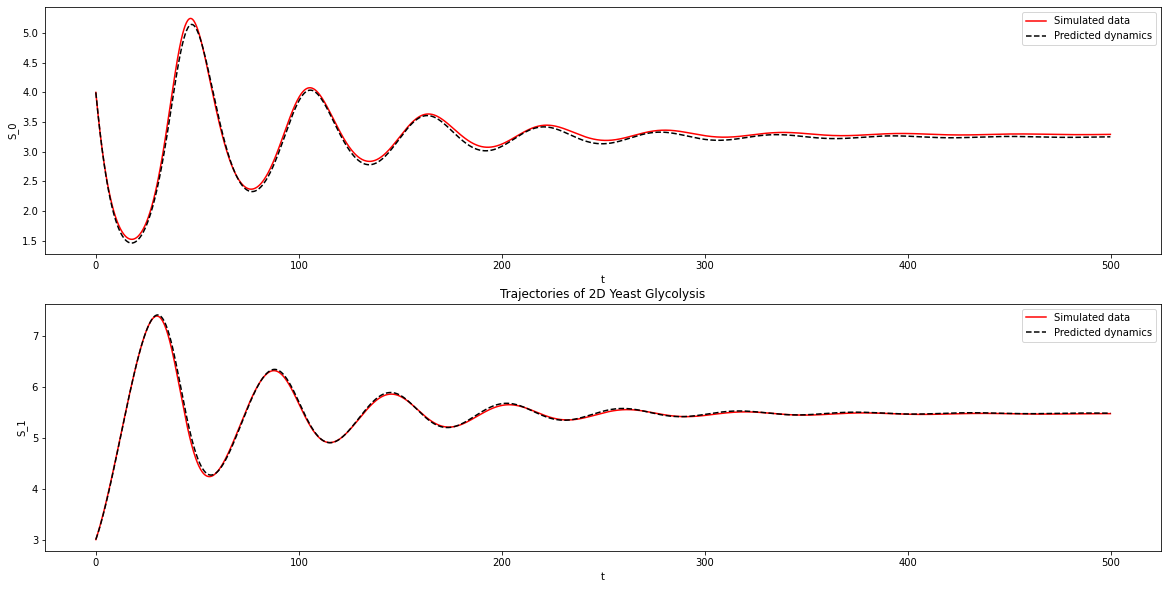

In [25]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

We see that the LmmNet is able to almost perfectly recover the dynamics of both species.

# Variants of LmmNet

In [1]:
import sys
sys.path.append("./source")
from model import *
from NovakTyson import *
from train import *
from predict import *
import matplotlib.pyplot as plt

In [5]:
# train the model
time_points, data_array = simulate_custom(step_size=0.4)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='L1') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=True)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

Epoch: 0, Time: 0.12, Loss: 1.3119e+00
Epoch: 100, Time: 5.46, Loss: 1.0061e-01
Epoch: 200, Time: 10.63, Loss: 7.5115e-02
Epoch: 300, Time: 15.82, Loss: 7.0989e-02
Epoch: 400, Time: 21.20, Loss: 7.5680e-02
Epoch: 500, Time: 26.37, Loss: 8.1837e-02
Epoch: 600, Time: 31.56, Loss: 6.0136e-02
Epoch: 700, Time: 36.71, Loss: 6.0573e-02
Epoch: 800, Time: 41.87, Loss: 5.2468e-02
Epoch: 900, Time: 47.04, Loss: 4.5041e-02
Epoch: 1000, Time: 52.18, Loss: 4.6130e-02
Epoch: 1100, Time: 57.44, Loss: 4.7718e-02
Epoch: 1200, Time: 62.70, Loss: 4.5057e-02
Epoch: 1300, Time: 67.86, Loss: 5.2195e-02
Epoch: 1400, Time: 73.37, Loss: 3.8786e-02
Epoch: 1500, Time: 78.64, Loss: 3.6298e-02
Epoch: 1600, Time: 83.83, Loss: 4.1442e-02
Epoch: 1700, Time: 89.07, Loss: 3.8500e-02
Epoch: 1800, Time: 94.44, Loss: 5.7508e-02
Epoch: 1900, Time: 99.58, Loss: 4.9992e-02
Epoch: 2000, Time: 104.76, Loss: 4.5129e-02
Epoch: 2100, Time: 109.91, Loss: 5.3586e-02
Epoch: 2200, Time: 115.12, Loss: 4.5236e-02
Epoch: 2300, Time: 120

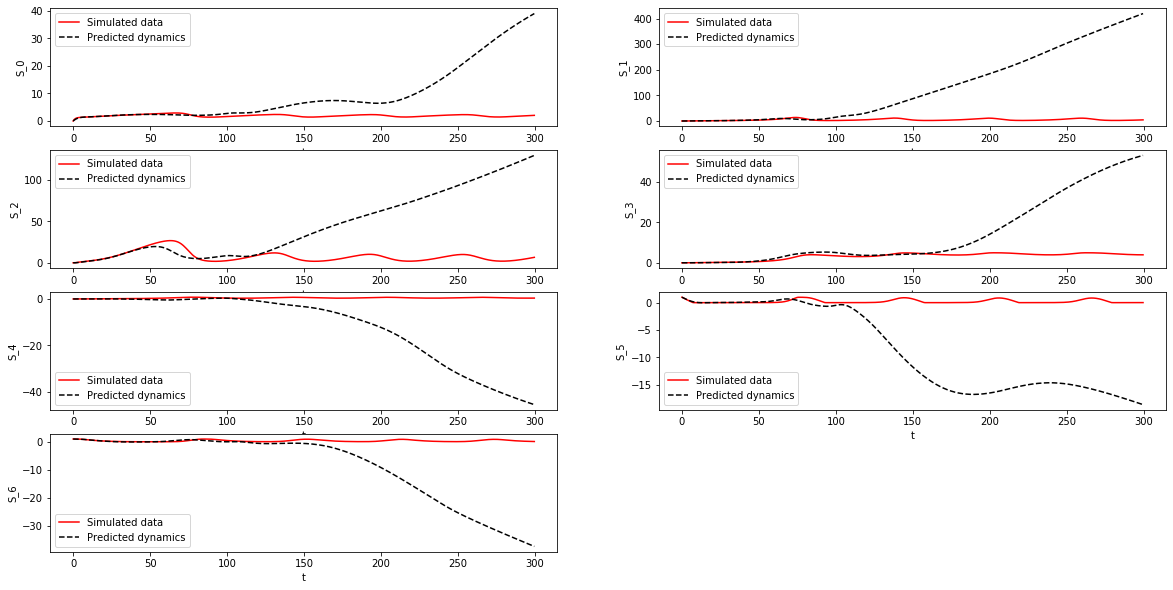

In [8]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))
plt.title('Trajectories of Cell Cycle Model')

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_points, data_array[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.show()

In [9]:
# train the model
time_points, data_array = simulate_custom(step_size=3.0)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='L1') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=False)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

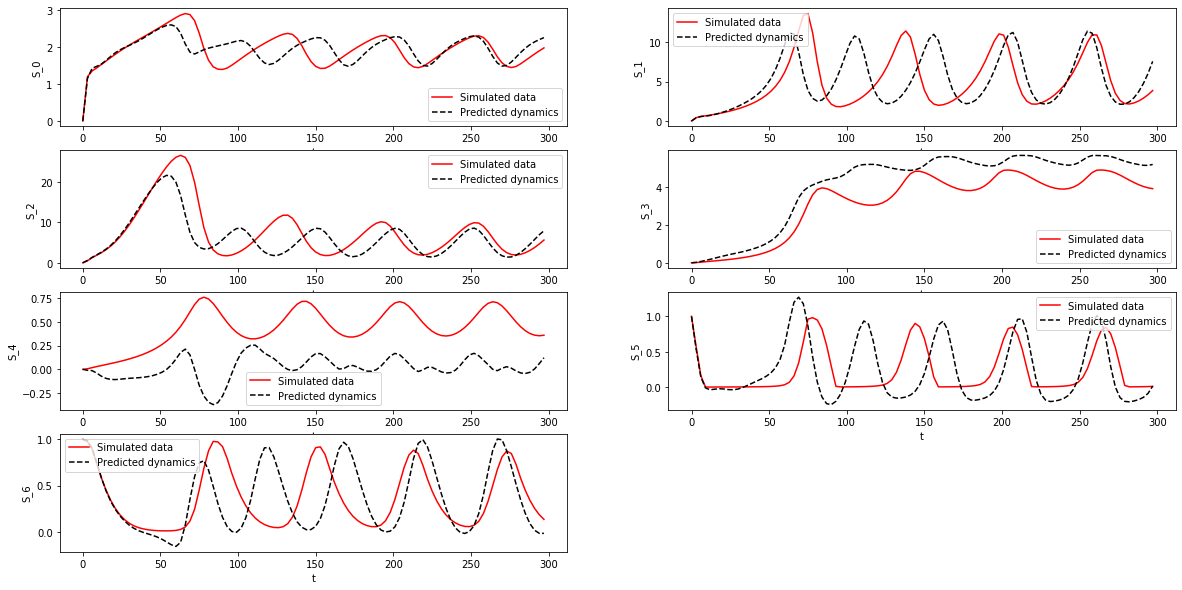

In [10]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))
plt.title('Trajectories of Cell Cycle Model')

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_points, data_array[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.show()

In [2]:
# train the model
time_points, data_array = simulate_custom(step_size=2.5)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='Wasserstein') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=False)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

ValueError: No gradients provided for any variable: ['dense_model/dense/kernel:0', 'dense_model/dense/bias:0', 'dense_model/dense_1/kernel:0', 'dense_model/dense_1/bias:0'].

RMSE: $||x_i - y_i||^2$

Wasserstein: minimum way to assign each $x_i$ to each $y_i$. This asssignment is equivalent to an optimal transport problem.